## Using pd.Category as a means of plotting data for multiple non-calendar years on the same X-axis

A lot of the work I do for my current job builds towards a non-calander year deadline.  This adds a bit more complication for time series analysis.  In an effort to compare current year metrics against prior years, I used pd.Category() along with pandas datetime plotting.  This allowed the prior year quantities to be aligned with the current year data along the X-axis.

Process:
1. identify day of year that each quantity is associated with
1. form list of adjusted day of year ordering (based on current year)
1. map day of year to adjusted day of year ordering
1. assign index as dates of current year (pd.date_range)

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
# create range of years
# from 2015 - 2020
years = pd.DataFrame(pd.date_range(pd.to_datetime('2015'), pd.to_datetime(pd.to_datetime('2021-12-31')))) \
    .squeeze().apply(lambda x: x.year).value_counts().sort_index()

In [4]:
# take a look at years and number of days per year
years

2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
Name: 0, dtype: int64

#### Example plot without using pd.Category()

In [190]:
# create empty df to hold years data
all_years = pd.DataFrame()
all_years_non_stacked = pd.DataFrame()

# for loop 
for i, v in zip([str(x) for x in years.index], years.values):
    
    # for each year generate random data for each day of the year
    date_rng = pd.date_range(pd.to_datetime(pd.to_datetime(f'{i}')), pd.to_datetime(pd.to_datetime(f'{i}-12-31')))
    
    year = pd.DataFrame(np.random.randint(10, size=(date_rng.shape[0], 1)), 
                  columns=[i], 
                  index=date_rng)
    
    # add a bit more irregularity to the data
    year.loc[year[i] == 5] = np.random.randint(100)
       
    # combine all years into example df
    # where years are not stacked along x-axis
    all_years_non_stacked = pd.concat([
        all_years_non_stacked,
        year
    ], axis=1)
    
    # assign index for each year 
    # to be day of year quantity for each year
    year.index = year.index.dayofyear
    
    # combine all years into single df
    all_years = pd.concat([
        all_years,
        year
    ], axis=1)

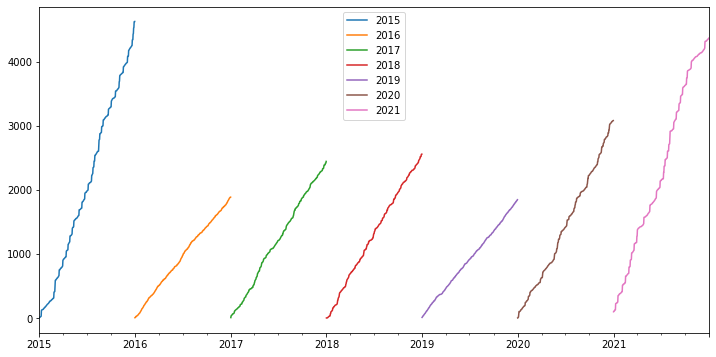

In [191]:
all_years_non_stacked.cumsum().plot(figsize=(12, 6));

#### Each year is plotted on its own.  This is not what I want.  Instead, I would like them to all share the same axis of the current year.  That way, as the current year unfolds I can easily track the comparison.  To accomplish this I need to use pd.Category() in combination with all transactions assigned to each "day of year" that they took place.

In [195]:
# all years combined
# with day of year as index
all_years.head()

,2015,2016,2017,2018,2019,2020,2021
1,4.0,4,6.0,0.0,9.0,0,97.0
2,2.0,2,24.0,1.0,4.0,2,9.0
3,3.0,3,8.0,0.0,9.0,9,0.0
4,4.0,13,3.0,0.0,7.0,3,3.0
5,6.0,0,3.0,4.0,4.0,43,9.0


#### Example scenario with 10/1 - 9/31 calander year

In [196]:
# create two lists and
# add them together
# to create sequencing we want
adj_day_sequence = [x for x in range(pd.to_datetime('2021-10-1').dayofyear, pd.to_datetime('2021-12-31').dayofyear + 2)] + \
[x for x in range(1, pd.to_datetime('2021-9-30').dayofyear + 1)]

In [197]:
len(adj_day_sequence)

366

The number of days will need to be one day longer to accomodate some years that have 366 days.

In [198]:
# review sequencing
str(adj_day_sequence)

'[274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 1

In [199]:
# assign index to be adjusted index sequencing
all_years.index = pd.Categorical(all_years.index, categories=adj_day_sequence, ordered=True)

In [200]:
all_years.isna().sum()

2015    1
2016    0
2017    1
2018    1
2019    1
2020    0
2021    1
dtype: int64

We can see that except for the two years with 366 days, we have NaN values.

In [201]:
# we can see which row as the NaNs

all_years[all_years.isna().sum(axis=1) > 0]

,2015,2016,2017,2018,2019,2020,2021
366,NaN,0,NaN,NaN,NaN,1,NaN


In [202]:
# fill NaN values with zero so that cumsum()
# does not leave them as empty in the sequence.
all_years.fillna(0, inplace=True)

In [203]:
# find cumulative sum for all years
all_years = all_years.sort_index().cumsum()

In [204]:
# take a peek at the data
# we can see that the amounts increase
# towards the last day of the year
all_years

,2015,2016,2017,2018,2019,2020,2021
274,1.0,8,8.0,8.0,7.0,2,3.0
275,8.0,10,12.0,11.0,16.0,9,5.0
276,95.0,14,12.0,17.0,20.0,18,8.0
277,104.0,16,15.0,23.0,27.0,26,15.0
278,113.0,20,17.0,27.0,35.0,29,21.0
...,...,...,...,...,...,...,...
269,4609.0,1870,2402.0,2535.0,1828.0,3032,4347.0
270,4613.0,1876,2426.0,2538.0,1829.0,3032,4349.0
271,4615.0,1877,2432.0,2540.0,1836.0,3075,4351.0
272,4624.0,1881,2441.0,2548.0,1839.0,3079,4359.0


### Since 2021 isn't complete remove data from randomly generated data for dates that haven't happened yet

In [205]:
# create list with days in the future
future_days = [x for x in range(pd.to_datetime(datetime.datetime.today()).dayofyear, pd.to_datetime('2021-9-30').dayofyear + 1)]

In [206]:
str(future_days)

'[157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273]'

In [207]:
# fill future days with nan values
all_years.loc[future_days, '2021'] = None

In [208]:
# take a look at the data
# we can see NaNs filled in
all_years.tail(10).style.highlight_null(null_color='yellow')

,2015,2016,2017,2018,2019,2020,2021
264,4503.000000,1841,2389.000000,2486.000000,1798.000000,2894,nan
265,4590.000000,1848,2393.000000,2514.000000,1806.000000,2897,nan
266,4598.000000,1852,2394.000000,2520.000000,1815.000000,2940,nan
267,4601.000000,1858,2395.000000,2526.000000,1823.000000,2946,nan
268,4603.000000,1867,2402.000000,2526.000000,1827.000000,2989,nan
269,4609.000000,1870,2402.000000,2535.000000,1828.000000,3032,nan
270,4613.000000,1876,2426.000000,2538.000000,1829.000000,3032,nan
271,4615.000000,1877,2432.000000,2540.000000,1836.000000,3075,nan
272,4624.000000,1881,2441.000000,2548.000000,1839.000000,3079,nan
273,4625.000000,1885,2442.000000,2556.000000,1845.000000,3079,nan


In [209]:
# assign index to current year dates
# since 2 of our years have 366 days we will need to add an extra day
# rather than stopping at 2021-09-30
all_years.index = pd.date_range(pd.to_datetime('2020-10-1'), pd.to_datetime('2021-10-1'))

In [210]:
all_years.sort_index()

,2015,2016,2017,2018,2019,2020,2021
2020-10-01,1.0,8,8.0,8.0,7.0,2,3.0
2020-10-02,8.0,10,12.0,11.0,16.0,9,5.0
2020-10-03,95.0,14,12.0,17.0,20.0,18,8.0
2020-10-04,104.0,16,15.0,23.0,27.0,26,15.0
2020-10-05,113.0,20,17.0,27.0,35.0,29,21.0
...,...,...,...,...,...,...,...
2021-09-27,4609.0,1870,2402.0,2535.0,1828.0,3032,NaN
2021-09-28,4613.0,1876,2426.0,2538.0,1829.0,3032,NaN
2021-09-29,4615.0,1877,2432.0,2540.0,1836.0,3075,NaN
2021-09-30,4624.0,1881,2441.0,2548.0,1839.0,3079,NaN


We can see that the dates are sorted in order that we want them.

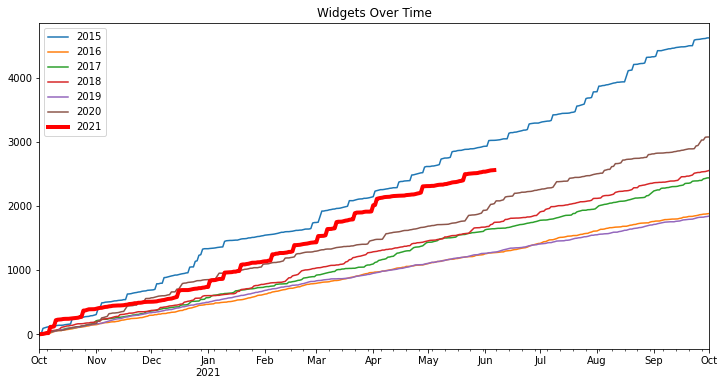

In [212]:
# plot all years except current yera
all_years.iloc[:,:-1].plot(figsize=(12, 6), title='Widgets Over Time')


# highlight current year by 
# plotting in red with extra thickness
all_years.iloc[:,-1].plot(linewidth=4, color='red')
plt.legend(list(all_years.columns));

#### The final result shows us how we are tracking against cumulative sum amounts from prior years.